In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4267 files belonging to 10 classes.


In [14]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [15]:
len(dataset)

134

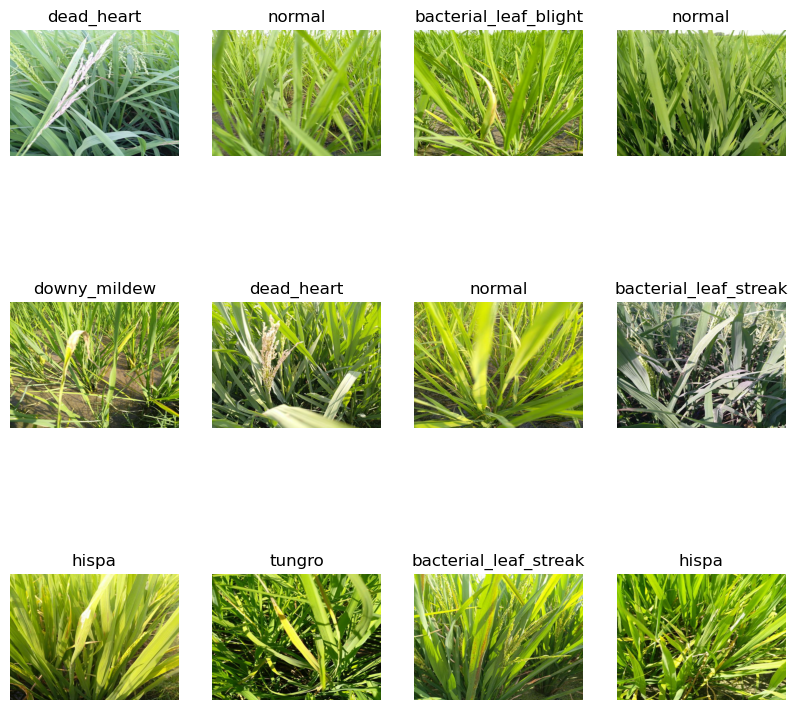

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")


In [16]:
 len(dataset)

134

In [17]:
# 80% ==> training
# 20% ==> 10% validation, 10% test -> to find the accuracy on these 10% then to the launch to outer data

In [18]:
train_size = 0.8
len(dataset)*train_size

107.2

In [21]:
train_ds = dataset.take(107)
len(train_ds)

107

In [22]:
test_ds = dataset.skip(107) #actually not test dataset it is actually further split into validation and test
len(test_ds)

27

In [24]:
val_size = 0.1
len(dataset)*val_size

13.4

In [25]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [26]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [27]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)


107

In [30]:
len(val_ds)

13

In [31]:
len(test_ds)

14

In [34]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
Val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [35]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
107/107 [==============================] - 230s 2s/step - loss: 2.2396 - accuracy: 0.1443 - val_loss: 2.2810 - val_accuracy: 0.1250
Epoch 2/50
107/107 [==============================] - 270s 3s/step - loss: 2.2275 - accuracy: 0.1772 - val_loss: 2.2133 - val_accuracy: 0.2115
Epoch 3/50
107/107 [==============================] - 220s 2s/step - loss: 2.0946 - accuracy: 0.2557 - val_loss: 2.1527 - val_accuracy: 0.2452
Epoch 4/50
107/107 [==============================] - 470s 4s/step - loss: 1.9814 - accuracy: 0.2983 - val_loss: 1.9596 - val_accuracy: 0.3197
Epoch 5/50
107/107 [==============================] - 222s 2s/step - loss: 1.8669 - accuracy: 0.3406 - val_loss: 1.8292 - val_accuracy: 0.3822
Epoch 6/50
107/107 [==============================] - 215s 2s/step - loss: 1.8336 - accuracy: 0.3532 - val_loss: 1.7438 - val_accuracy: 0.4038
Epoch 7/50
107/107 [==============================] - 223s 2s/step - loss: 1.7404 - accuracy: 0.3850 - val_loss: 1.6861 - val_accuracy: 0.4159

In [43]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 22s 395ms/step - loss: 0.9188 - accuracy: 0.6897


In [44]:
scores

[0.9188414812088013, 0.6897321343421936]

In [46]:
history

In [47]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 107}

In [48]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
type(history.history['loss']) #its a list storing

list

In [50]:
len(history.history['loss'])

50

In [51]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.2395966053009033,
 2.2275145053863525,
 2.0946333408355713,
 1.9814109802246094,
 1.866921067237854]

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

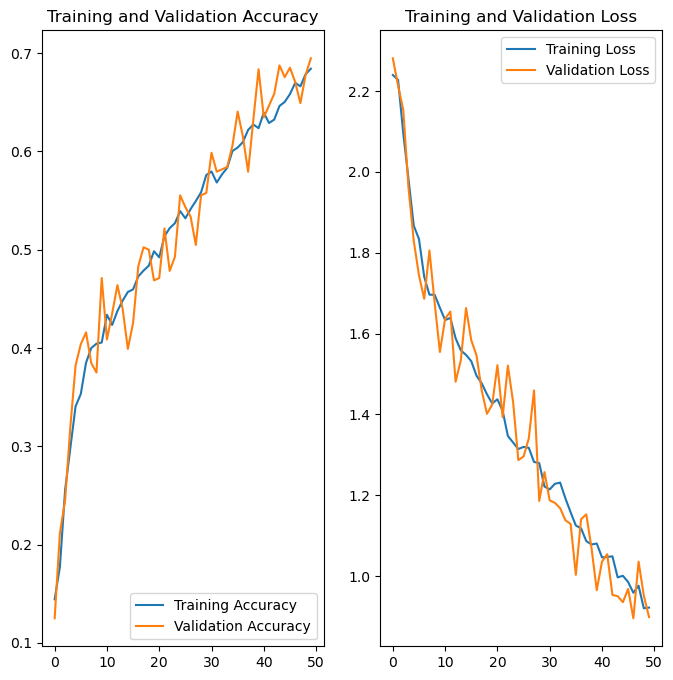

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image| to predict
actual label: downy_mildew
1/1 [==============================] - 0s 327ms/step
predicted label: downy_mildew


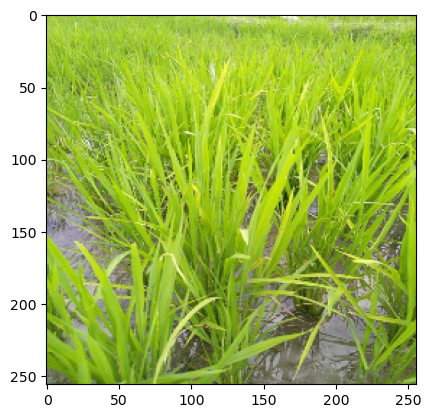

In [69]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image| to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
# Set the number of additional epochs
additional_epochs = 10

# Get the number of epochs already trained
initial_epochs = len(history.history['loss'])

# Run additional training epochs
history = model.fit(
    train_ds,
    epochs=initial_epochs + additional_epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    initial_epoch=initial_epochs
)

Epoch 51/60
107/107 [==============================] - 216s 2s/step - loss: 0.9142 - accuracy: 0.6835 - val_loss: 0.9496 - val_accuracy: 0.6755
Epoch 52/60
107/107 [==============================] - 214s 2s/step - loss: 0.9068 - accuracy: 0.6844 - val_loss: 0.8690 - val_accuracy: 0.7067
Epoch 53/60
107/107 [==============================] - 213s 2s/step - loss: 0.8606 - accuracy: 0.7041 - val_loss: 0.9230 - val_accuracy: 0.6947
Epoch 54/60
107/107 [==============================] - 213s 2s/step - loss: 0.8877 - accuracy: 0.6964 - val_loss: 1.1047 - val_accuracy: 0.6178
Epoch 55/60
107/107 [==============================] - 215s 2s/step - loss: 0.8376 - accuracy: 0.7111 - val_loss: 1.0660 - val_accuracy: 0.6278
Epoch 56/60
107/107 [==============================] - 215s 2s/step - loss: 0.8328 - accuracy: 0.7103 - val_loss: 0.7198 - val_accuracy: 0.7266
Epoch 57/60
107/107 [==============================] - 211s 2s/step - loss: 0.7992 - accuracy: 0.7270 - val_loss: 0.7588 - val_accuracy:

first image| to predict
actual label: normal
1/1 [==============================] - 0s 299ms/step
predicted label: normal


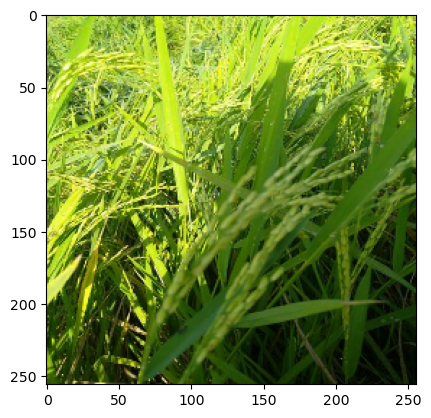

In [86]:
 import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image| to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #Create a batch
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


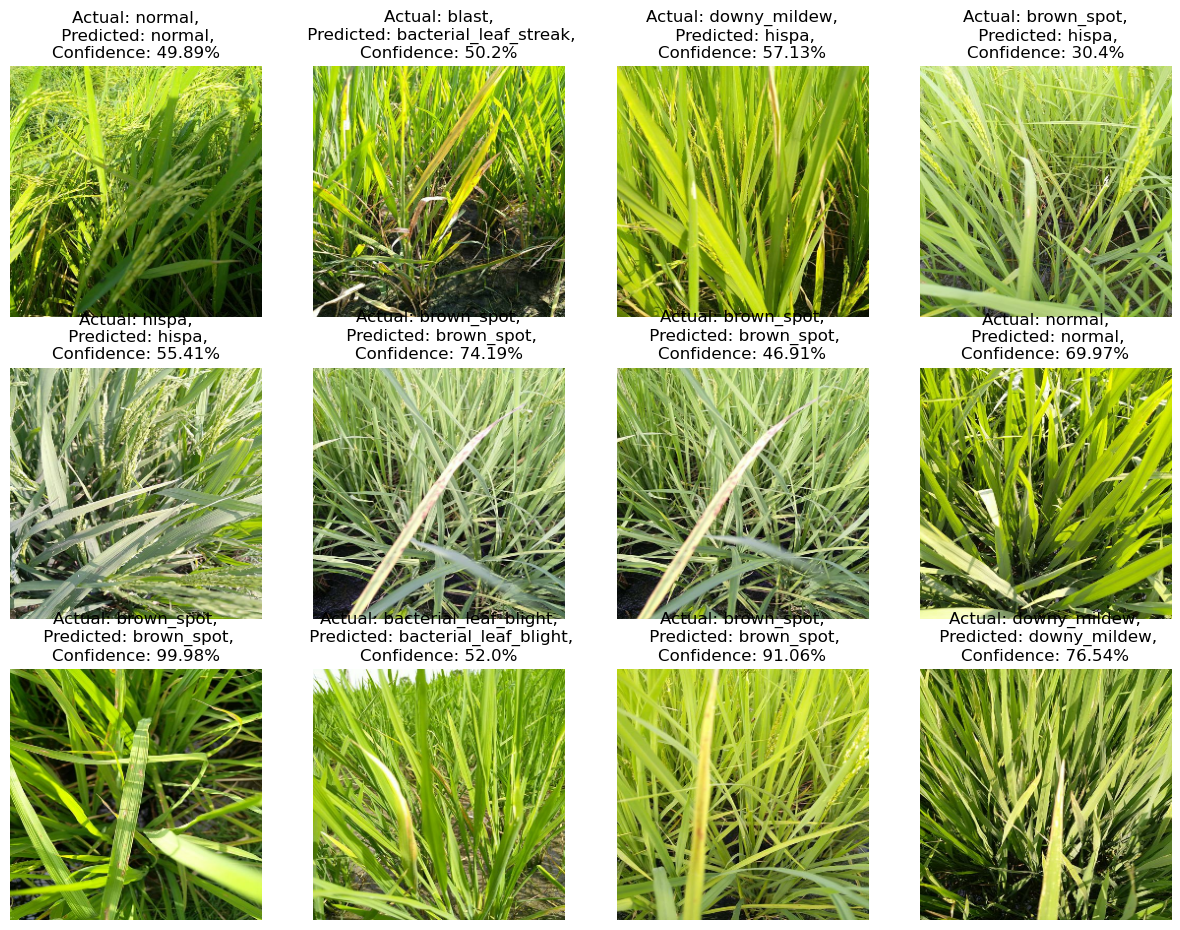

In [98]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
                  
                  

In [102]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets
